In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
# imports
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy.integrate import solve_ivp

# Add parent directory to sys.path
from pathlib import Path
current_path = Path.cwd()
parent_dir = current_path.parent.parent
sys.path.append(str(parent_dir))

# Import necessary modules
from src.train import run_model_new
from src.utils_plot import plot_loss_and_all_solution, plot_head_loss
from src.load_save import save_model

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [5]:
def check_versions_and_device():
  # set the device to the GPU if it is available, otherwise use the CPU
  current_dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  !nvidia-smi
  return current_dev

# set a global device variable to use in code
dev = check_versions_and_device()
print(dev)

Thu Jan 11 15:31:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   41C    P0              N/A /   5W |      0MiB /  2048MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [11]:
num_heads = 4

alpha_list = [1, 2, 3, 4] # stiffness parameter
A_list = [torch.tensor([[0., -1.], [1., 2*i]], device=dev).double() for i in alpha_list]
force_list = [torch.tensor([[0.], [0.]], device=dev).double() for _ in range(num_heads)]
IC_list = [torch.tensor([[1.], [0.5]], device=dev).double() for _ in range(num_heads)]

def random_IC(x_bound=[0, 2], y_bound=[0, 2]):
    ICx = np.random.uniform(x_bound[0], x_bound[1], 1)
    ICy = np.random.uniform(y_bound[0], y_bound[1], 1)
    return torch.tensor([ICx, ICy], device=dev).double()
#IC_list = [random_IC() for i in range(num_heads)]

def random_force(force1_bound=[0, 2], force2_bound=[0, 2]):
    force1 = np.random.uniform(force1_bound[0], force1_bound[1], 1)
    force2 = np.random.uniform(force2_bound[0], force2_bound[1], 1)
    return torch.tensor([force1, force2], device=dev).double()
#force_list = [random_force() for i in range(num_heads)]

equation_name = "DHO"

In [12]:
x_range = [0, 10]
activation = "tanh"
hid_lay = list(np.array([124, 124, 132]) * 1)
num_equations = 2
iterations = 100

In [13]:
# function to numerically compute the solution to any set of two coupled, linear first-order ODES
def double_coupled_equation(t, y, A, force):
    return np.array([force[0].detach().item() - A[0][1] * y[1] - A[0][0] * y[0],
                     force[1].detach().item() - A[1][0] * y[0] - A[1][1] * y[1]])

numerical_sol_fct = lambda x, v, A, force: (solve_ivp(double_coupled_equation, [x_range[0], x_range[1]],
                                                    v.squeeze(), args=(A, force), t_eval=x.squeeze(), method="Radau").y)

In [46]:
head_to_track = 'head 1'
is_A_time_dep = False
is_force_time_dep = False
sample_factor = 1
lr = 0.0005
verbose = True

sample_size = 512
decay=True

# run model which has two non-coupled equations
# loss_hist, trained_model, model_time, MSE_hist = run_model(iterations=iterations, x_range=x_range, lr=lr,
#                                                            A_list=A_list, v_list=IC_list, force=force_list,
#                                                            hid_lay=hid_lay, activation=activation,
#                                                            num_equations=num_equations, num_heads=num_heads,
#                                                            true_functs=numerical_sol_fct, head_to_track=head_to_track,
#                                                            sample_factor = sample_factor, is_A_time_dep=is_A_time_dep,
#                                                            is_force_time_dep=is_force_time_dep, dev=dev, verbose=verbose)

loss_hist, trained_model, model_time = run_model_new(iterations=iterations, x_range=x_range, lr=lr, A_list=A_list, 
                                                  v_list=IC_list, force=force_list, hid_lay=hid_lay, activation=activation,
                                                  num_equations=num_equations, num_heads=num_heads, sample_size=sample_size,
                                                  decay=decay, dev=dev, verbose=verbose)

# date tag to save
from datetime import datetime
now = datetime.now()
# Format the date and time as a string in the format 'mmddhhmm'
formatted_datetime = now.strftime('%m%d%H%M')
# Convert the formatted string to an integer
formatted_datetime_int = int(formatted_datetime)

  2%|▏         | 2/100 [00:00<00:13,  7.29it/s]

Iterations 0: loss = 0.8673832283673466


100%|██████████| 100/100 [00:05<00:00, 18.36it/s]

Model Training Complete in 5.474 seconds


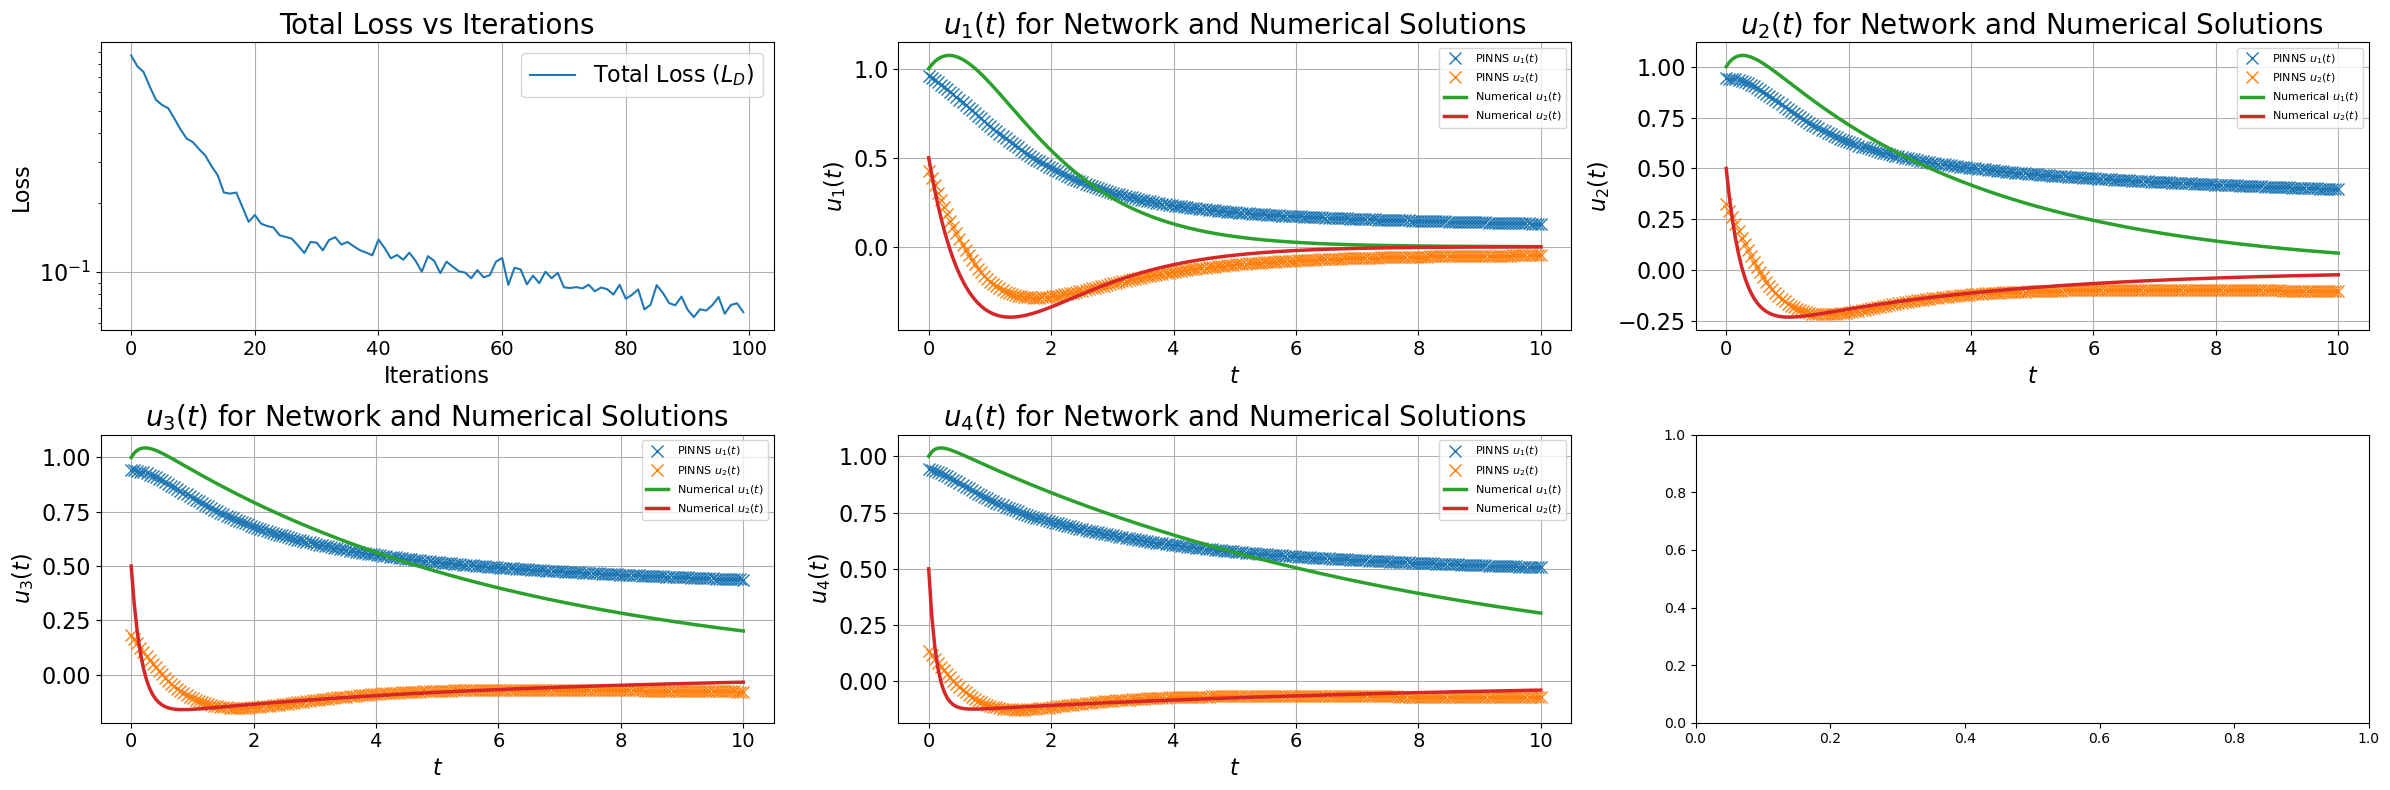

In [47]:
plot_loss_and_all_solution(x_range=x_range, true_functs=numerical_sol_fct,
                           trained_model=trained_model, v_list=IC_list, A_list=A_list,
                           force=force_list, train_losses=loss_hist['L_total'],
                           loss_label='Total Loss ($L_D$)', device=dev)

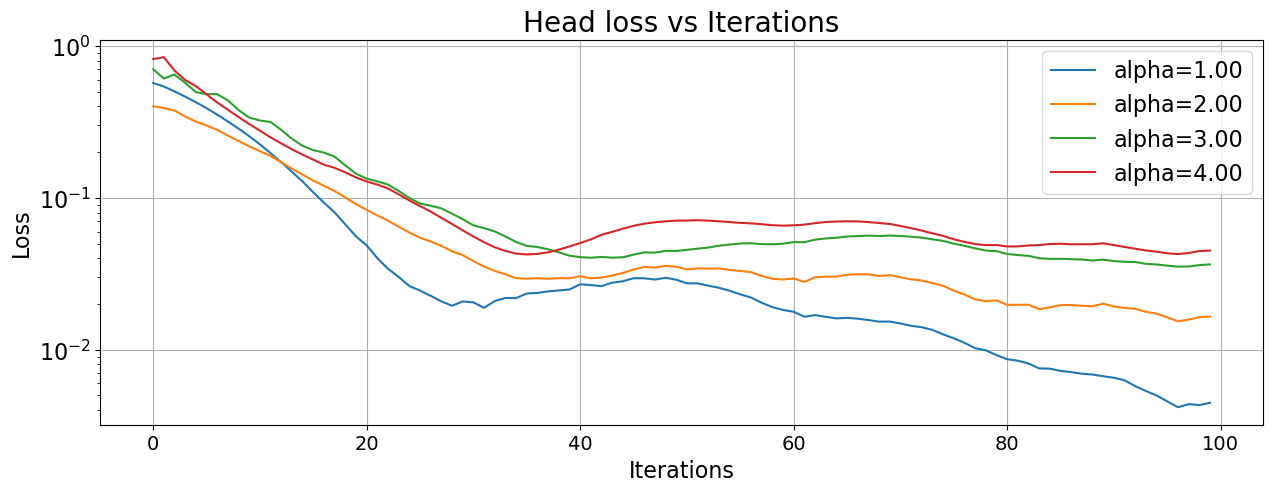

In [48]:
plot_head_loss(loss_hist["head"], alpha_list)

In [49]:
model_name = "test"

save_model(trained_model, formatted_datetime_int, equation_name, model_name,
           x_range, iterations, hid_lay, num_equations, num_heads, A_list,
           IC_list, force_list, alpha_list, is_A_time_dep, loss_hist)

D:\Emilien\Documents\Cours\Master_Thesis\Harvard_Master_Thesis\model_history/DHO/history_test_1111543.json
